In [1]:
import urllib.request, json 
import pickle
import pandas as pd
import numpy as np
import re

In [2]:
def get_json(_url):
    with urllib.request.urlopen(_url) as url:
        data = json.loads(url.read().decode())
        return data

In [3]:
def get_votes(_afstemnings_id):
    a = get_json("https://oda.ft.dk/api/Afstemning("+str(_afstemnings_id)+")/Stemme?$inlinecount=allpages")
    if a["odata.nextLink"]:
        b = get_json(a["odata.nextLink"])
        for stemme in b["value"]:
            a["value"].append(stemme)
    return a

In [4]:
def get_actor(_actor_id):
    data = get_json("https://oda.ft.dk/api/Akt%C3%B8r("+str(_actor_id)+")")
    name = data["navn"]
    biografi = data["biografi"]
    party = None
    if not(biografi is None):
        res = re.findall("<party>(.*)<\/party>", biografi)
        if(len(res) > 0):
            party = res[0]
    return {"name": name, "party": party}    

In [5]:
afstemninger = {}
actors = {}

In [6]:
def get_cleaned_votes(_afstemning):
    if _afstemning in afstemninger:
        return afstemninger[_afstemning]
    votes = ["for", "imod", "fraværende"]
    ugly_votes = get_votes(_afstemning)
    cleaned_votes = []
    for stemme in ugly_votes["value"]:
        aktørid = stemme["aktørid"]
        if not(aktørid in actors):
            actors[aktørid] = get_actor(aktørid)
        cleaned_votes.append({"vote": stemme["typeid"], "actor": actors[aktørid]["name"]})
    return cleaned_votes

In [7]:
def load_data_day(year, month, day):
    long_url = "https://oda.ft.dk/api/Afstemning?$inlinecount=allpages&$filter=year(opdateringsdato)%20eq%20"+str(year) + "%20and%20month(opdateringsdato)%20eq%20"+str(month)+"%20and%20day(opdateringsdato)%20eq%20"+str(day)
    votes_today = get_json(long_url)
    
    for afstemning in votes_today["value"]:
        afstemnings_id = afstemning["id"]
        if afstemnings_id in afstemninger:
            continue
        afstemninger[afstemnings_id] = {"votes": get_cleaned_votes(afstemnings_id), "nummer": afstemning["nummer"]}

In [37]:
def load_data():
    for month in range(6, 13):
        print(".", end="")
        for day in range(1, 32):
            load_data_day(2017, month, day)

In [38]:
#load_data()

..

URLError: <urlopen error [Errno 111] Connection refused>

In [10]:
if True:
    df = pd.DataFrame(index=["name"], columns=["id", "party"])
    for a_id in actors:
        df.loc[actors[a_id]["name"]] = [a_id, actors[a_id]["party"]]

    for a_id in afstemninger:
        print(".", end="")
        df[a_id] = 0
        for stemme in afstemninger[a_id]["votes"]:
            df.loc[stemme["actor"], a_id] = stemme["vote"]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Load

In [13]:
print(len(actors))
print(len(afstemninger))

486
1482


In [12]:
actors = pickle.load(open("actors.p", "rb"))
afstemninger = pickle.load(open("afstemninger.p", "rb"))
df = pd.read_pickle("data_frame.pkl")

### Save

In [11]:
pickle.dump(actors, open("actors.p", "wb"))
pickle.dump(afstemninger, open("afstemninger.p", "wb"))
df.to_pickle("data_frame.pkl")

# The fun begins
Remember that the votes can be one of 4:
1. Vote for
2. Vote against
3. Do not care
4. Not there

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [16]:
df_clean = df.dropna()
df_clean = df_clean.replace(4, 0)

In [17]:
df_clean.loc["Pia Adelsteen"].value_counts()

1                   552
0                   397
2                   276
3                   257
221                   1
Dansk Folkeparti      1
Name: Pia Adelsteen, dtype: int64

In [18]:
features = df_clean.columns[2:].values
X = df_clean.loc[:, features]
Y = df_clean.loc[:, "party"]

In [19]:
X = StandardScaler().fit_transform(X)

/home/lasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/lasse/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, index=df_clean.index, columns=["principal component 1", "principal component 2"])

In [31]:
parties = ['Dansk Folkeparti', 'Socialdemokratiet', 'Radikale Venstre', 'Venstre', 'Liberal Alliance', 'Socialistisk Folkeparti',
       'Det Konservative Folkeparti', 'Enhedslisten', 'Alternativet', None]
colors = ["yellow", "orange", "purple", "blue", "blue", "red", "green", "red", "red", "black"]

In [32]:
kendte = ["Helle Thorning-Schmidt", "Per Stig Møller", "Søren Pape", "Eva Kjer Hansen", "Rasmus Jarlov", "Karsten Lauritzen", "Holger K. Nielsen", "Bertel Haarder", "Inger Støjberg", "Troels Lund Poulsen", "Mette Bock", "Trine Bramsen", "Jakob Ellemann-Jensen", "Christian Langballe", "Merete Riisager", "Zenia Stampe", "Martin Lidegaard", "Laura Lindahl", "Søren Gade", "Anders Stjernholm", "Claus Hjort Frederiksen", "Pia Kjærsgaard", "Nicolai Wammen", "Kristian Thulesen Dahl", "Lars Løkke Rasmussen", "Kristian Jensen", "Mogens Lykketoft", "Mette Frederiksen", "Henrik Sass Larsen", "Naser Khader", "Peter Skaarup", "Anders Samuelsen", "Christine Antorini", "Søren Pind", "Morten Østergaard", "Søren Espersen", "Simon Emil Ammitzbøll-Bille", "Uffe Elbæk", "Martin Henriksen", "Pia Olsen Dyhr", "Johanne Schmidt-Nielsen", "Sophie Løhde", "Joachim B. Olsen", "Esben Lunde Larsen", "Dan Jørgensen", "Mette Abildgaard", "Bjarne Corydon", "Brian Mikkelsen", "Pernille Skipper", "Margrethe Vestager", "Erik Lund"]

In [39]:
finalDf = pd.concat([principalDf, df_clean[['party']]], axis = 1)

In [64]:
finalDf = finalDf[finalDf.index.isin(kendte)]

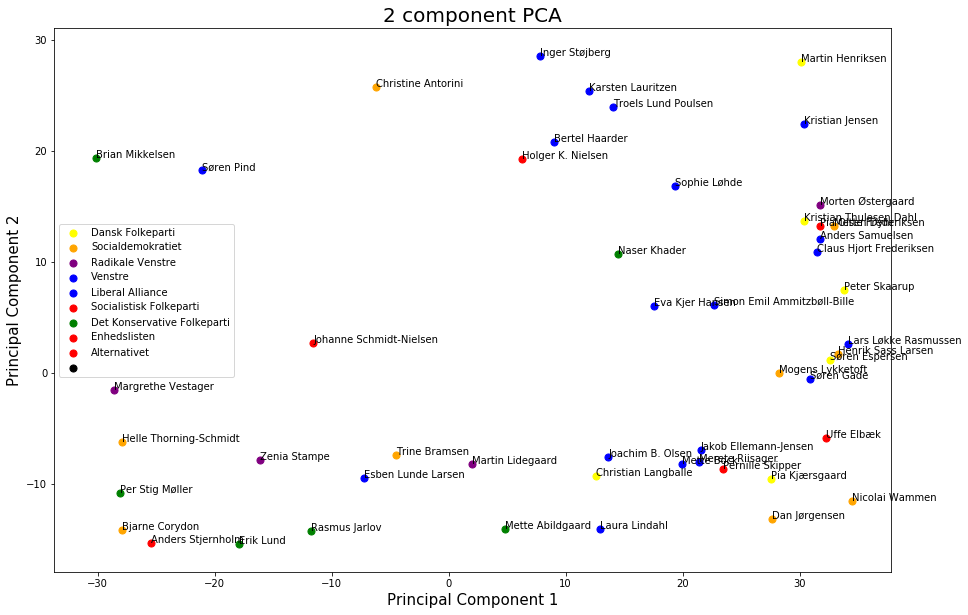

In [66]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = parties
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['party'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x, y, c = color, s = 50)

    for i, txt in enumerate(finalDf.loc[indicesToKeep].index):
        if txt in kendte:
            ax.annotate(txt, (x[i], y[i]))

ax.legend(targets)
plt.show()

# Most similar to

In [61]:
# a - a.loc['2005'].values.squeeze()
df_clean_2 = df_clean.replace(3, 0)
chosen_row =  df_clean_2.loc["Lars Løkke Rasmussen"]
df_lars = df_clean_2.apply(lambda row: row[2:] == chosen_row[2:] , axis=1)

In [78]:
(chosen_row[2:] == 2).sum()

84

In [79]:
df_lars.sum()

3913    165
3914    168
3915    169
3918    168
3919    168
3920    168
3921    168
3916    172
3917    169
3922    167
3923    166
3924    173
3925    166
3        49
243     172
244     172
245     172
246     174
278     174
279     187
280     174
281     176
282     188
296     171
297     201
298     176
299     212
300     172
301     178
302     175
       ... 
7125    168
7126    168
7127    168
7128    167
7129    165
7130    166
7131    167
7132    165
7133    168
7134    168
7135    195
7136    166
7137    166
7138    169
7139    170
7140    168
7118    165
7141    176
7142    174
7143    176
7144    174
7145    173
7146    176
7147    175
7148    183
7149    175
7150    177
7151     54
7152     96
7153     55
Length: 1482, dtype: int64